In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from ibm_washington_config import coupling_map, basis_gates
from ionq_config import coupling_map, basis_gates

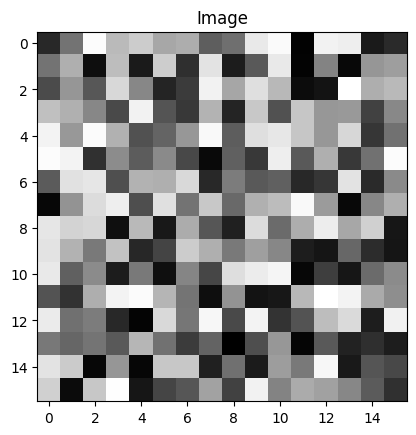

In [2]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [3]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [4]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\shrut\AppData\Local\Temp\ipykernel_13012\2498201748.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [5]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 2274, # of qubits is 9


In [10]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

C:\Users\shrut\AppData\Local\Temp\ipykernel_13012\4293248132.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


[42, 114, 256, 188, 201, 165, 183, 87, 107, 239, 256, 0, 256, 237, 26, 51, 95, 163, 0, 197, 36, 206, 35, 211, 34, 100, 227, 0, 142, 0, 145, 159, 69, 151, 75, 222, 138, 36, 47, 230, 170, 222, 185, 0, 18, 256, 180, 167, 201, 187, 131, 68, 256, 75, 37, 173, 18, 201, 82, 192, 149, 164, 67, 121, 238, 158, 256, 177, 77, 107, 152, 256, 74, 221, 229, 191, 147, 221, 47, 109, 256, 256, 54, 145, 99, 137, 75, 0, 96, 67, 216, 94, 183, 71, 130, 256, 84, 222, 256, 85, 173, 179, 225, 40, 136, 96, 105, 38, 63, 225, 41, 137, 0, 157, 211, 225, 77, 237, 123, 206, 103, 168, 175, 256, 160, 0, 143, 193, 229, 204, 207, 17, 168, 27, 164, 77, 27, 218, 107, 165, 256, 159, 207, 26, 209, 171, 133, 200, 26, 61, 202, 171, 115, 166, 115, 46, 18, 107, 41, 23, 237, 86, 160, 40, 125, 0, 129, 67, 238, 238, 256, 0, 93, 0, 111, 133, 81, 42, 162, 256, 236, 174, 111, 0, 135, 17, 25, 176, 256, 256, 157, 134, 236, 125, 128, 37, 0, 237, 101, 238, 54, 238, 59, 77, 172, 224, 43, 224, 123, 103, 137, 86, 178, 116, 42, 104, 0, 84, 1

In [11]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

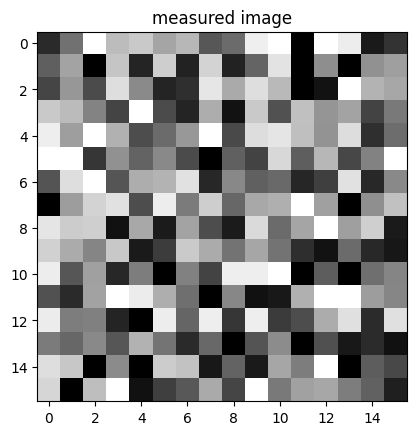

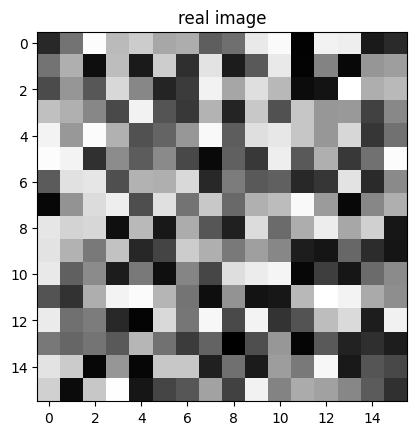

In [12]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)